In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
np.random.seed(46)
from matplotlib import style
style.use('fivethirtyeight')

2022-05-28 15:28:28.174752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-28 15:28:28.174797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir = r'/home/conan/Desktop/FYP/Module3/Datasets'
train_path = r'/home/conan/Desktop/FYP/Module3/Datasets/train'
test_path = r'/home/conan/Desktop/FYP/Module3/Datasets/test'


IMG_HEIGHT = 30
IMG_width = 30
channels = 3

In [3]:
categories=  len(os.listdir(train_path))
categories

43

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# Visualizing The Dataset

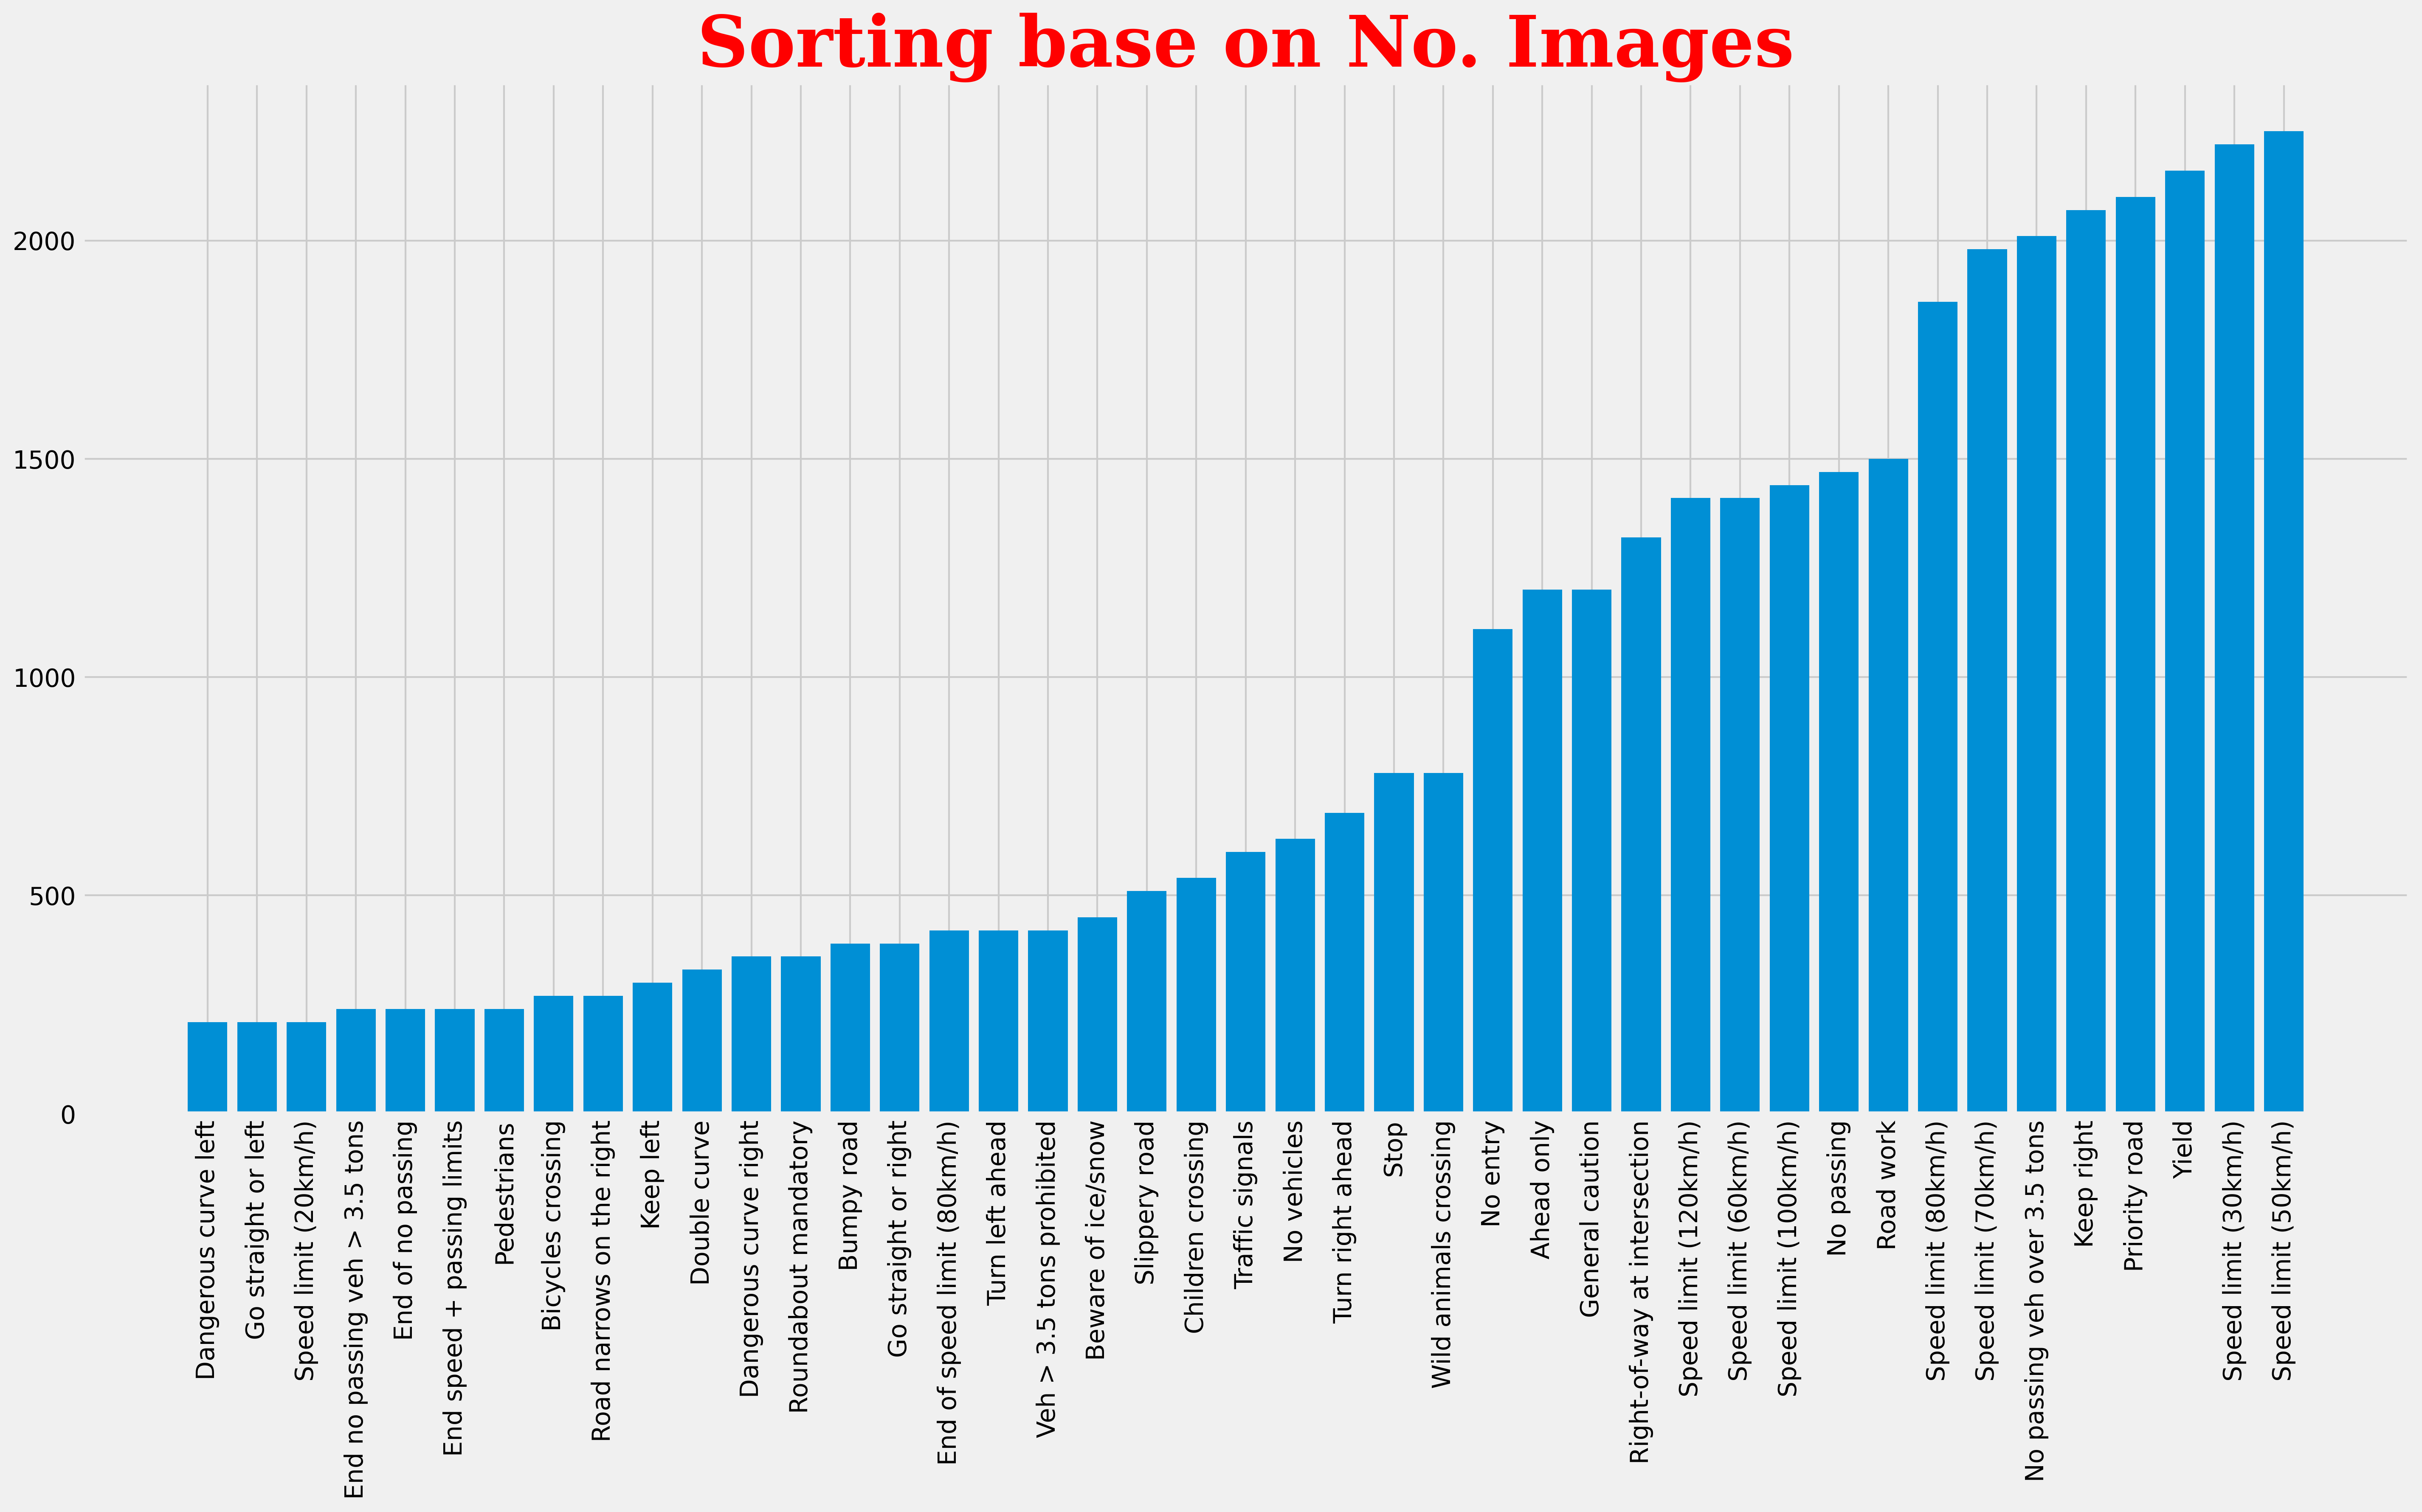

In [5]:
folders = os.listdir(train_path)
# folders

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path +'/'+ folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
    # Sorting the dataset on the basis of number of images in each class
    

zipped_list = zip(train_number, class_num)
sorted_pairs=  sorted(zipped_list)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]
    
    
font = {'family': 'serif',
        'color':  'red',
        'weight': 'bold',
        'size': 40,
        }
    
plt.figure(figsize=(21,10), dpi=300)
plt.bar(class_num, train_number)
plt.title("Sorting base on No. Images", fontdict=font)
plt.xticks(class_num, rotation='vertical')
plt.show()

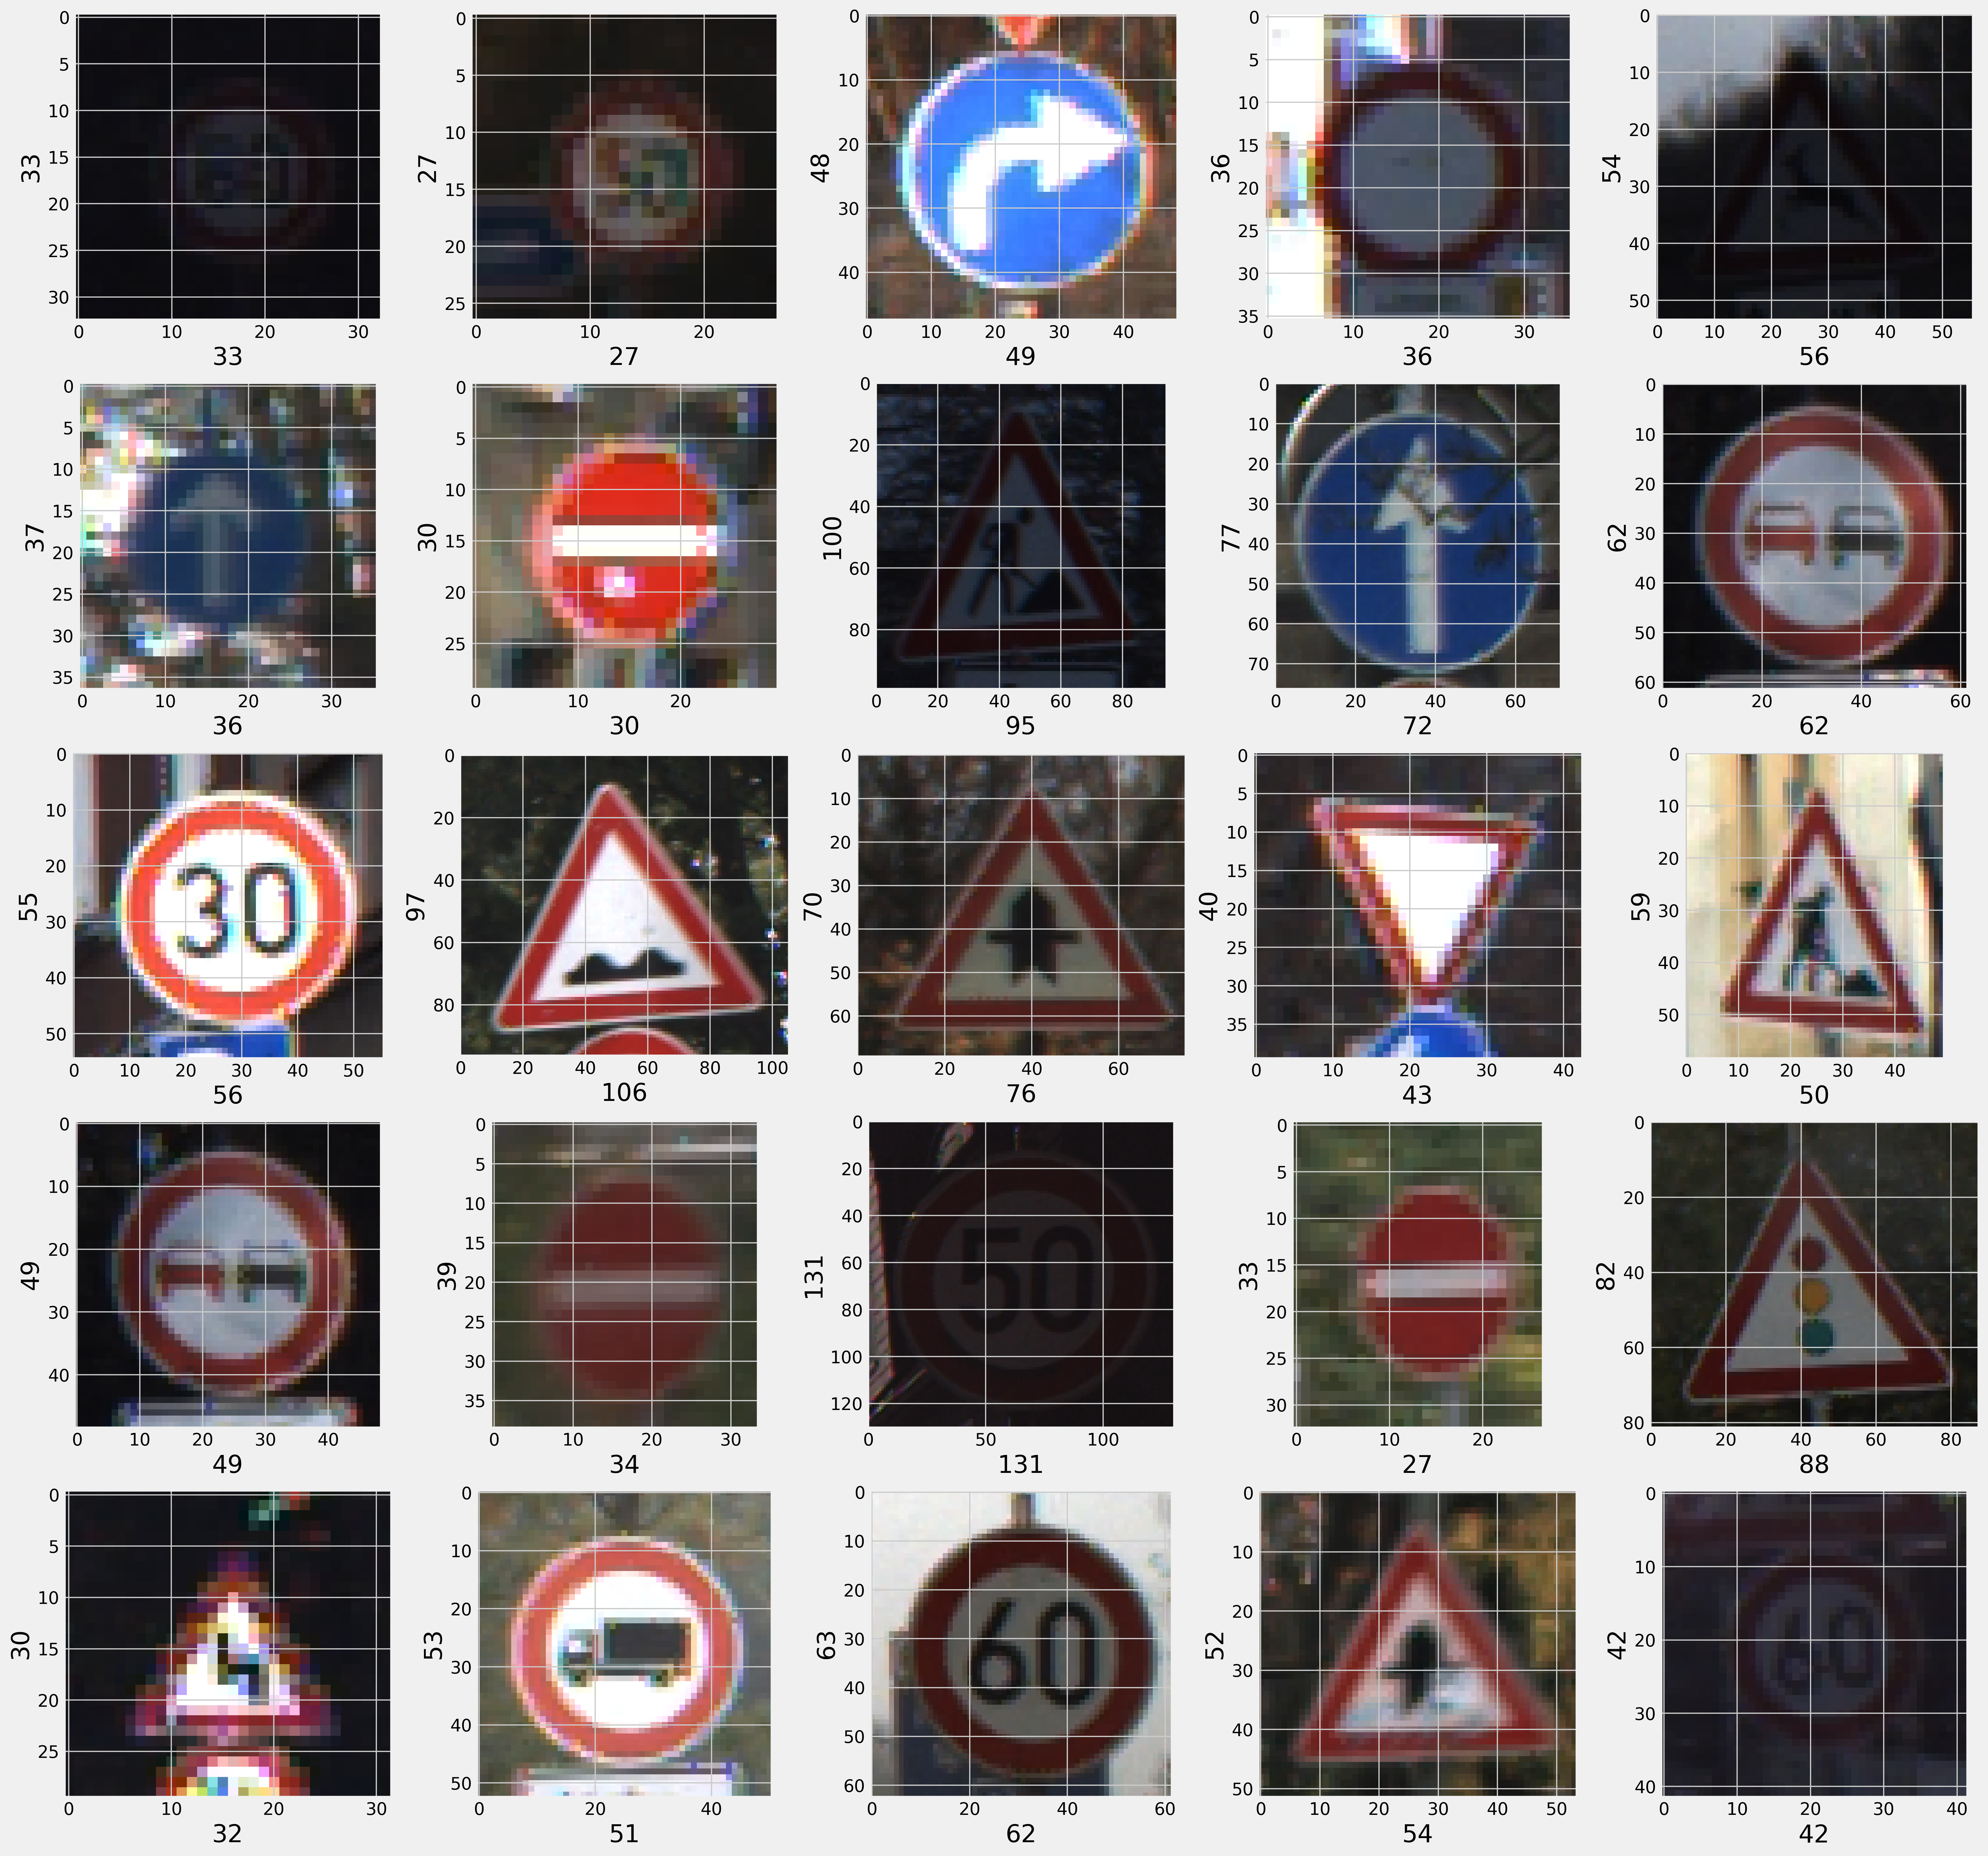

In [6]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir +'/Test.csv')
img = test['Path'].values

# print(img)

plt.figure(figsize=(25,25), dpi=300)

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img = data_dir + '/' + random.choice(img)
    rand_img = imread(random_img)
    plt.imshow(rand_img)
#     plt.grid(None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize=20)

# Collecting the Training Data

In [7]:
image_data = []
image_labels = []


for i in range(categories):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    
    for img in images:
        try:
            image = cv2.imread(path + '/' +img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_width))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in: "+img)
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


# Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# image_data.shape
# image_labels.shape

# Splitting the data into train and validation set

In [9]:
x_train, x_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)
x_train = x_train/255
x_val = x_val/255


print("X_train.shape: ", x_train.shape)
print("X_val.shape: ", x_val.shape)
print("Y_train.shape: ", y_train.shape)
print("Y_val.shape: ", y_val.shape)

X_train.shape:  (27446, 30, 30, 3)
X_val.shape:  (11763, 30, 30, 3)
Y_train.shape:  (27446,)
Y_val.shape:  (11763,)


# One hot encoding the labels

In [10]:
y_train = keras.utils.to_categorical(y_train, categories)
y_val = keras.utils.to_categorical(y_val, categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Making the model

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = "relu", input_shape= (IMG_HEIGHT, IMG_width, channels)),
    keras.layers.Conv2D(filters =32, kernel_size = (3,3), activation= "relu"),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.BatchNormalization(axis = -1),
    
    
    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"),
    keras.layers.Conv2D(filters =128, kernel_size = (3,3), activation= "relu"),
    keras.layers.MaxPool2D(pool_size = (2,2)),
    keras.layers.BatchNormalization(axis = -1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),
    
    keras.layers.Dense(43, activation="softmax")
    
    ])

2022-05-28 15:44:11.311859: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/conan/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-28 15:44:11.380492: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-28 15:44:11.499316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Conan): /proc/driver/nvidia/version does not exist


In [12]:
from tensorflow.keras.optimizers import Adam
lr= 0.001
epochs  = 5

opt = Adam(learning_rate= lr, decay = lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
aug = ImageDataGenerator(rotation_range=10,
                         zoom_range=0.15,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.15,
                         horizontal_flip=False,
                         vertical_flip=False,
                         fill_mode="nearest"
                        )

history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/5


2022-05-28 15:46:59.024250: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11384064 exceeds 10% of free system memory.
2022-05-28 15:46:59.024395: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11384064 exceeds 10% of free system memory.
2022-05-28 15:46:59.079634: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17981568 exceeds 10% of free system memory.
2022-05-28 15:46:59.079741: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 17981568 exceeds 10% of free system memory.
2022-05-28 15:46:59.089403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24920064 exceeds 10% of free system memory.


858/858 [==============================] - 319s 270ms/step - loss: 1.1188 - accuracy: 0.6995 - val_loss: 0.0808 - val_accuracy: 0.9788
Epoch 2/5
858/858 [==============================] - 168s 195ms/step - loss: 0.1793 - accuracy: 0.9459 - val_loss: 0.0351 - val_accuracy: 0.9904
Epoch 3/5
858/858 [==============================] - 101s 117ms/step - loss: 0.0971 - accuracy: 0.9713 - val_loss: 0.0339 - val_accuracy: 0.9893
Epoch 4/5
858/858 [==============================] - 100s 116ms/step - loss: 0.0730 - accuracy: 0.9781 - val_loss: 0.0151 - val_accuracy: 0.9963
Epoch 5/5
858/858 [==============================] - 100s 116ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0098 - val_accuracy: 0.9978


In [14]:
model.save('models/traffic_classifier_v2.h5', overwrite=True)

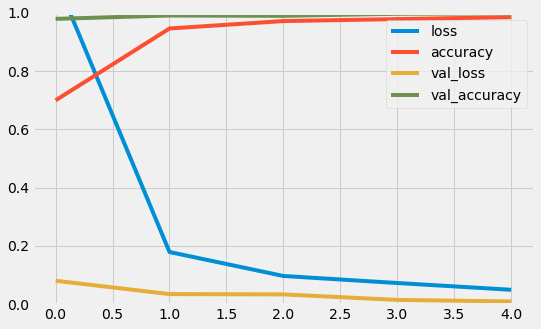

In [15]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Loading the test data and running the predictions

In [16]:
test2 = pd.read_csv(data_dir +'/Test.csv')

labels = test2['ClassId'].values
imgs = test2['Path'].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir +'/'+img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_width))
        data.append(np.array(resize_image))
    except:
        print("Error in: ", img)

X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=1)


#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.13935075217735


In [17]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot:>

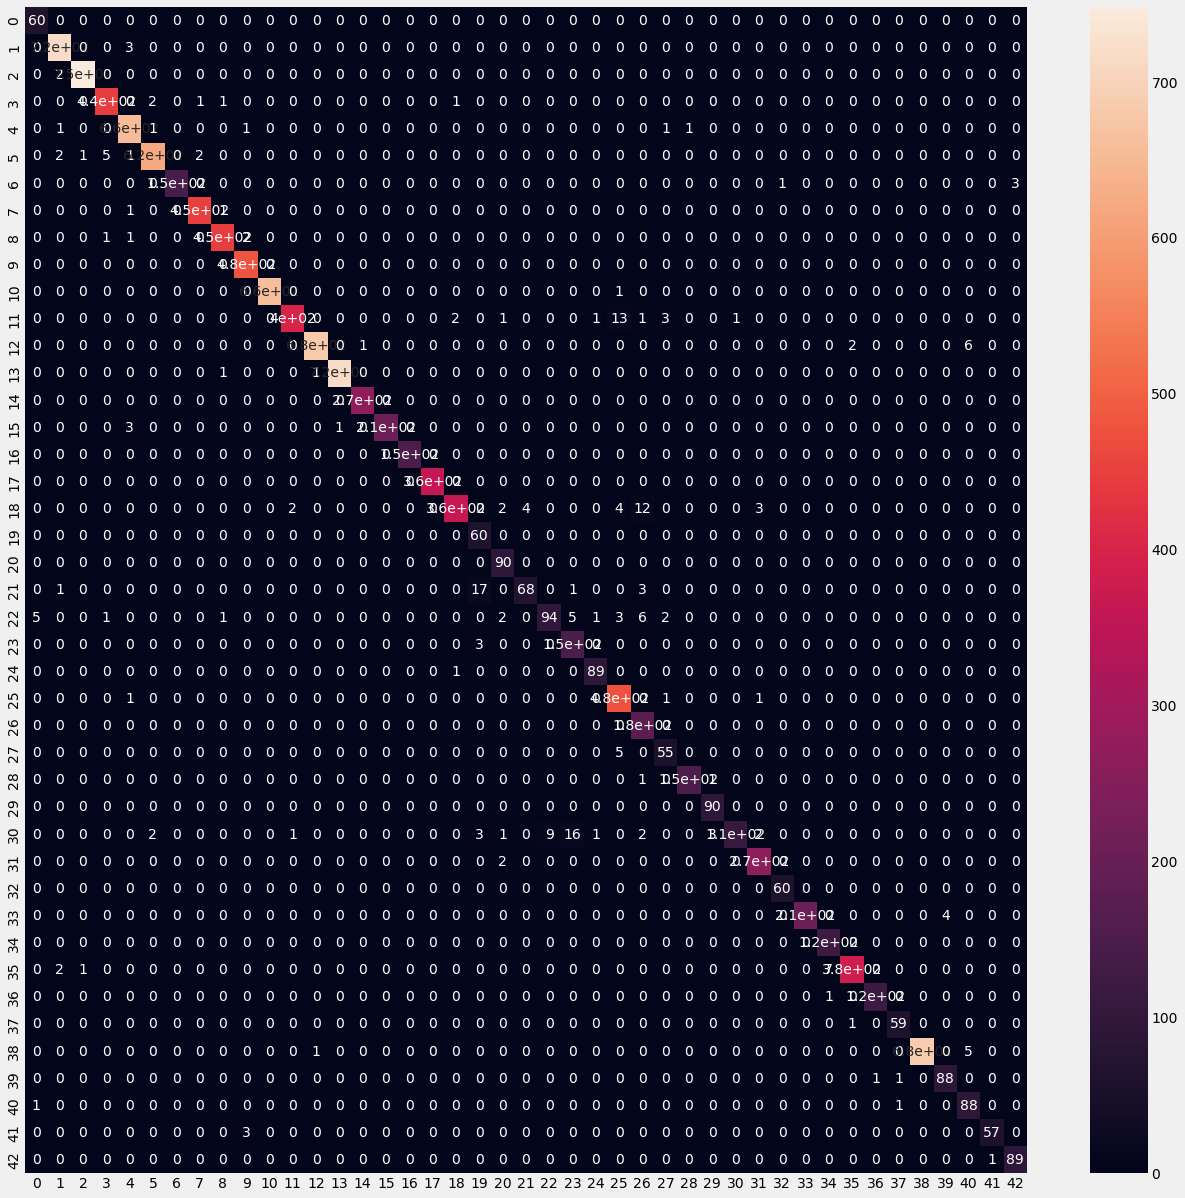

In [18]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        60
           1       0.99      1.00      0.99       720
           2       1.00      1.00      1.00       750
           3       0.98      0.99      0.99       450
           4       0.98      0.99      0.99       660
           5       0.99      0.98      0.99       630
           6       1.00      0.97      0.99       150
           7       0.99      1.00      0.99       450
           8       0.99      0.99      0.99       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      0.98      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

# Prediction

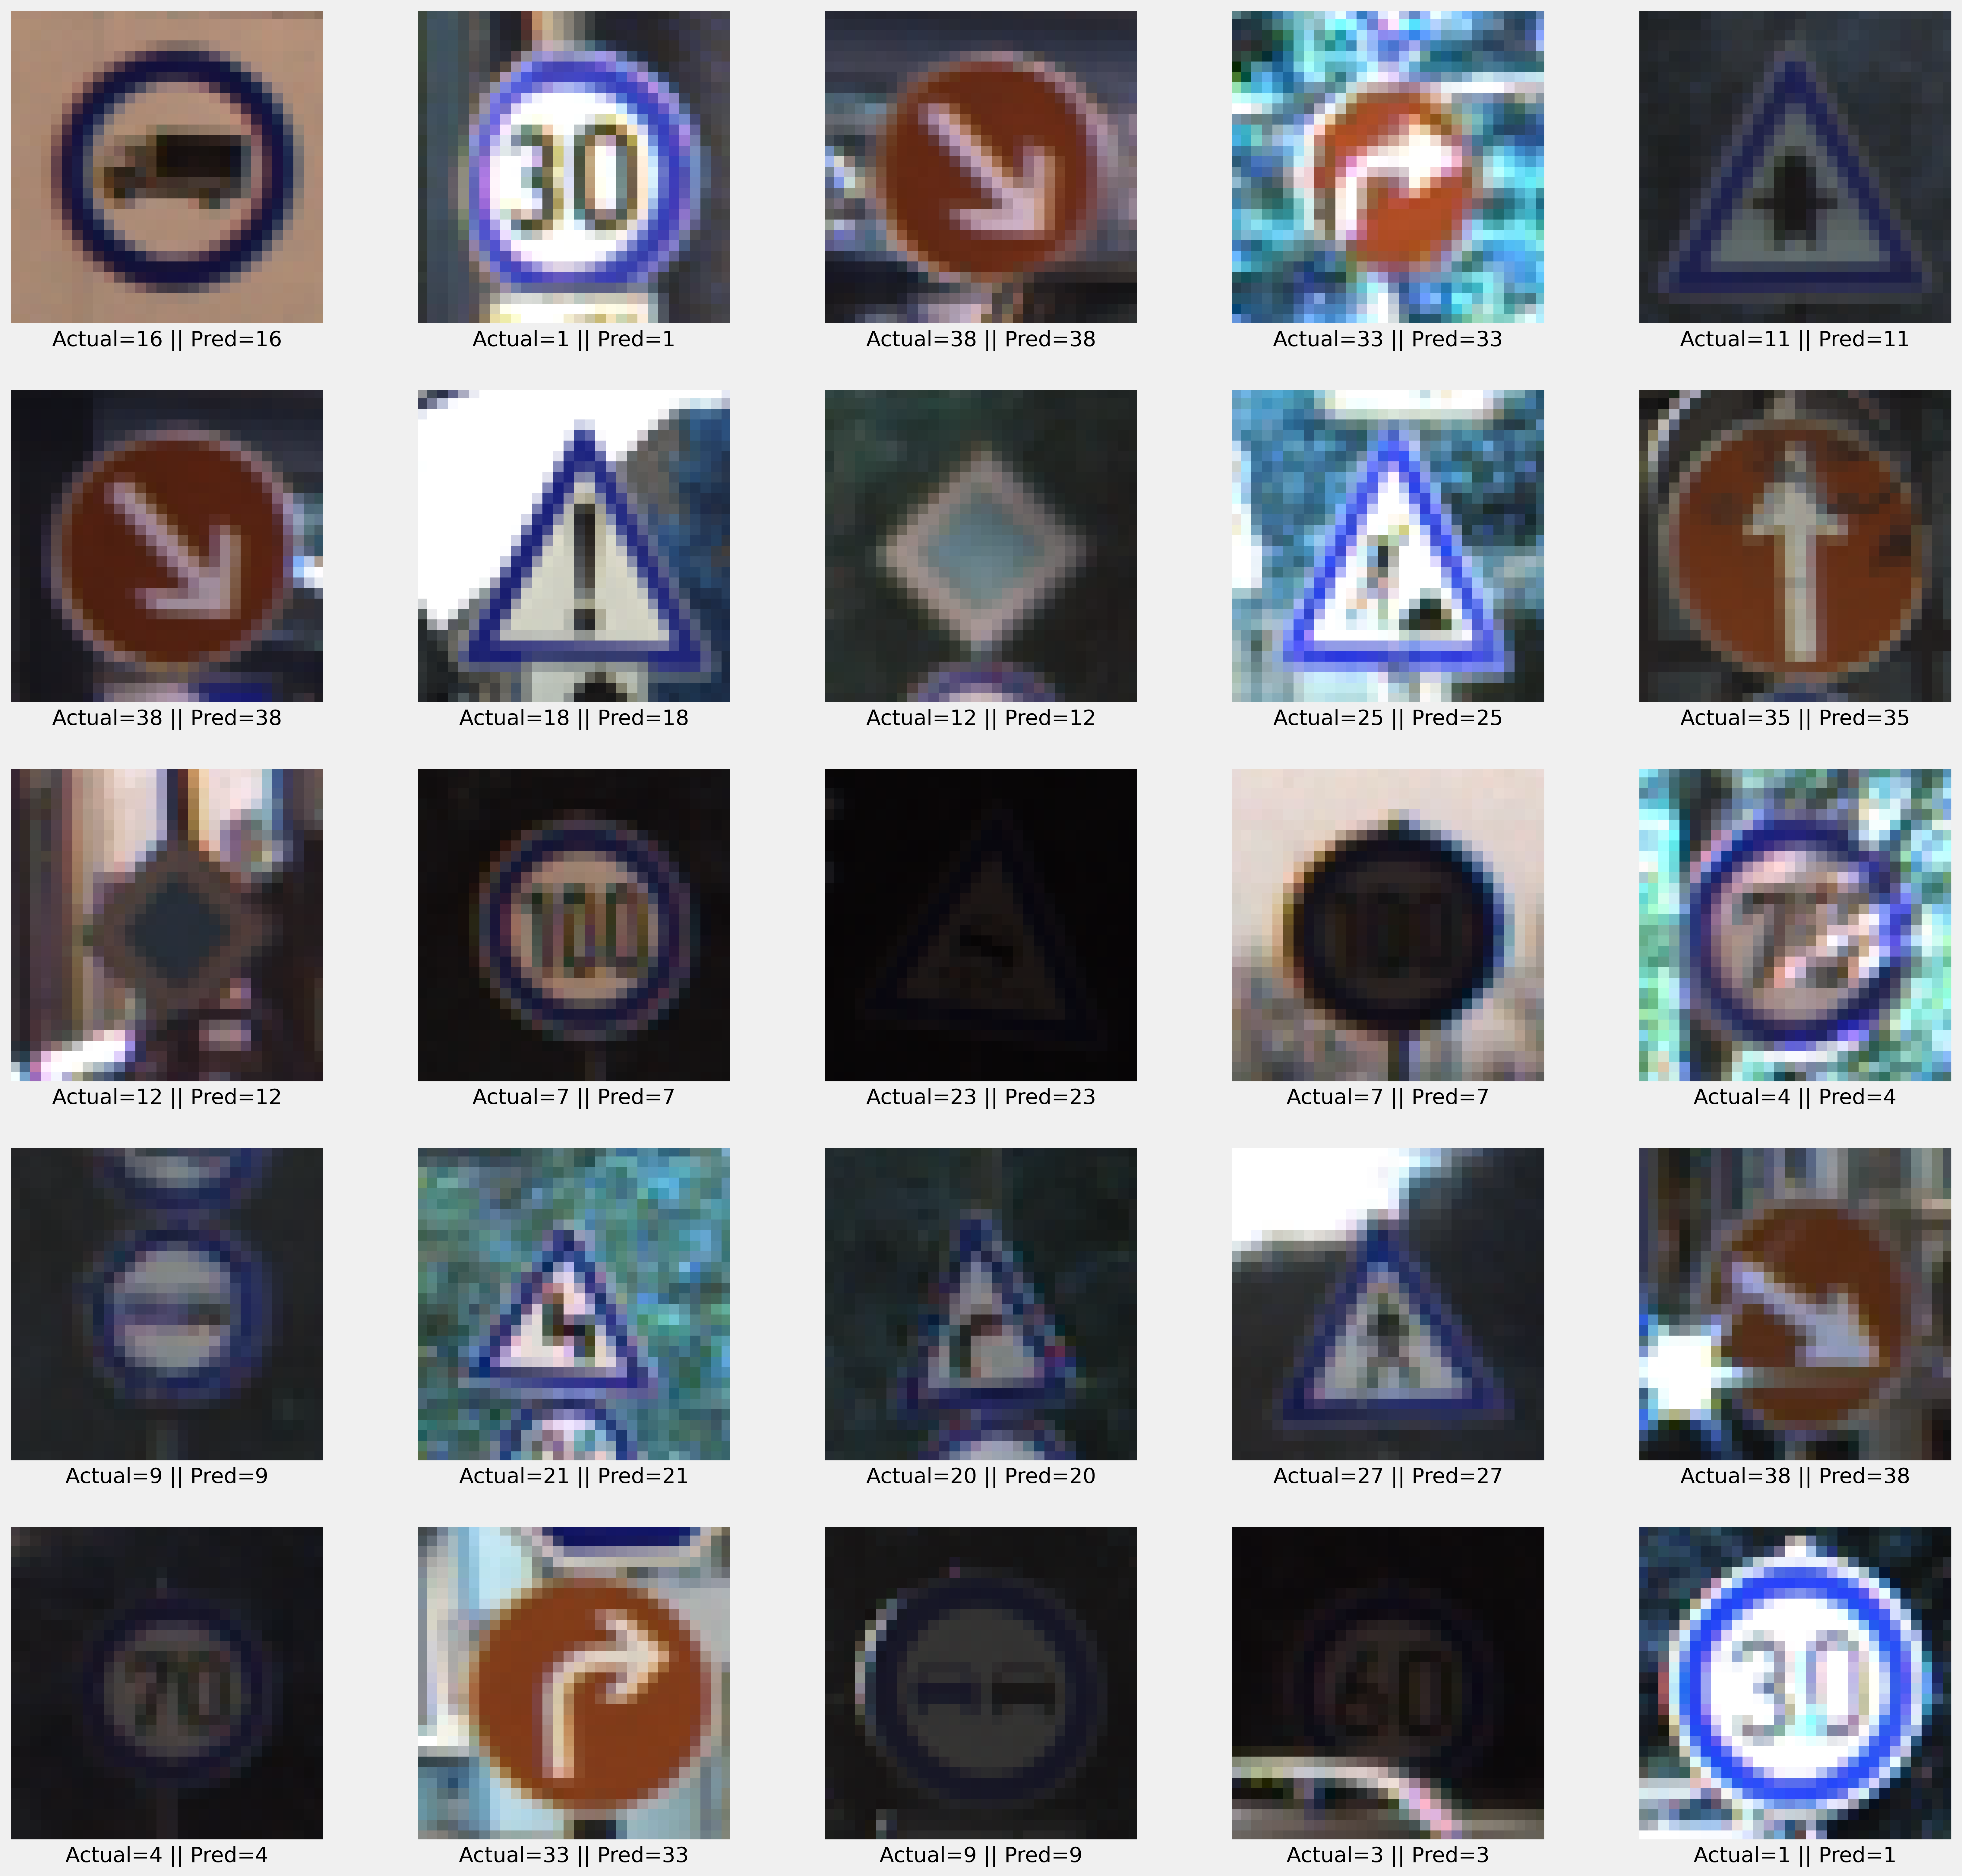

In [22]:
plt.figure(figsize = (25,25), dpi = 300)

start_index = 0

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index +i]
    actual = labels[start_index +i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction, color = col))
    plt.imshow(X_test[start_index+i])
plt.show()
    